In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import timedelta
from matplotlib.ticker import MultipleLocator


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

from sklearn import model_selection, preprocessing, metrics, tree
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import IsolationForest, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer ,confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection



%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

seed_val = 42

/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/venv-mercedes/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# constants
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data/'
SUBMISSION_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions'

In [3]:
# loading the data
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# reseting index
#train = train.set_index('ID')
#test = test.set_index('ID')

## Exploration

#### Full row duplicates

In [4]:
train_df_id_idx = train.set_index(['ID'], drop=True)
df = train_df_id_idx.drop(['y'], axis=1).duplicated(keep=False)
dupes_X = train_df_id_idx.drop(['y'], axis=1)[df]
dupe_ids = dupes_X.index.values
dupes = train_df_id_idx[train_df_id_idx.index.isin(dupe_ids)]
train_columns = list(set(dupes.columns) - set(['ID', 'y']))
mean_y = dupes.groupby(train_columns).y.mean().reset_index().rename(columns={'y':'mean_y'})
median_y = dupes.groupby(train_columns).y.median().reset_index().rename(columns={'y':'mean_y'})
variance_y = dupes.groupby(train_columns).y.var().reset_index().rename(columns={'y':'variance_y'})
std_y = dupes.groupby(train_columns).y.std().reset_index().rename(columns={'y':'std_y'})
temp = pd.merge(dupes, mean_y, on=train_columns, how='left')
temp = pd.merge(temp, median_y, on=train_columns, how='left')
temp = pd.merge(temp, variance_y, on=train_columns, how='left')
temp = pd.merge(temp, std_y, on=train_columns, how='left')
result = temp.sort_index().sort_values(train_columns)
result['residual_y'] = result.y - result.mean_y_x

mean: 7.45035101574e-16
std: 6.12685871481


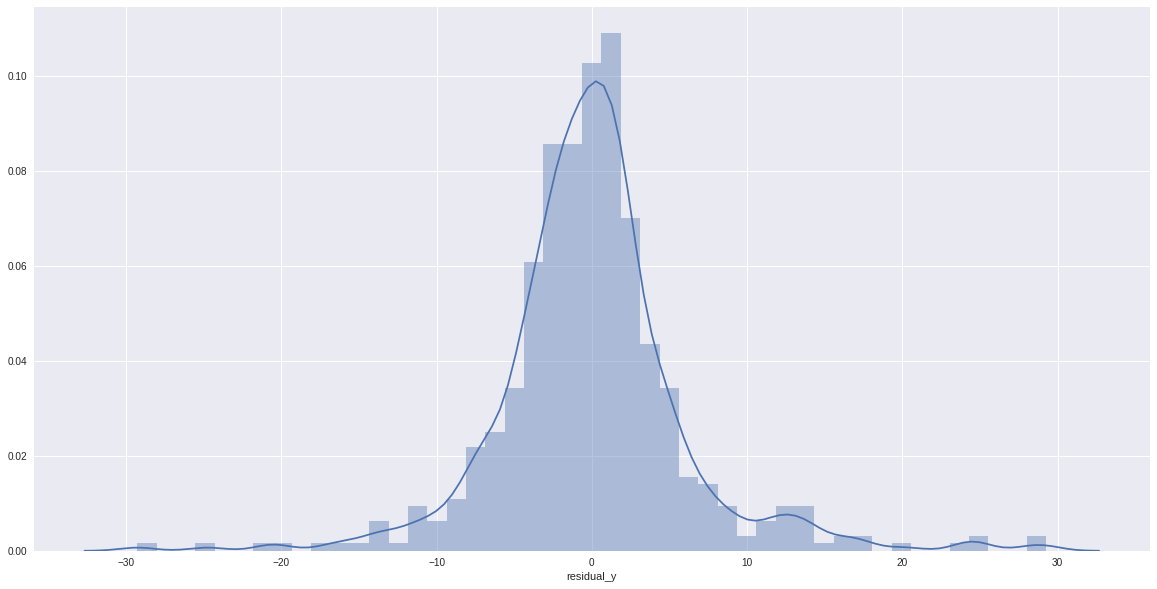

In [5]:
plt.figure(figsize=(20,10))
sns.distplot(result['residual_y'])
print('mean:', np.mean(result['residual_y']))
print('std:', np.std(result['residual_y']))

#### X0-X8 duplicates

In [6]:
train_df_id_idx = train.set_index(['ID'], drop=True)
tot_cols = train_df_id_idx.columns
tot_cols = set(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'y'])
train_df_id_idx = train_df_id_idx[list(tot_cols)]
df = train_df_id_idx.drop(['y'], axis=1).duplicated(keep=False)
dupes_X = train_df_id_idx.drop(['y'], axis=1)[df]
dupe_ids = dupes_X.index.values
dupes = train_df_id_idx[train_df_id_idx.index.isin(dupe_ids)]
train_columns = list(set(dupes.columns) - set(['ID', 'y']))
mean_y = dupes.groupby(train_columns).y.mean().reset_index().rename(columns={'y':'mean_y'})
median_y = dupes.groupby(train_columns).y.median().reset_index().rename(columns={'y':'mean_y'})
variance_y = dupes.groupby(train_columns).y.var().reset_index().rename(columns={'y':'variance_y'})
std_y = dupes.groupby(train_columns).y.std().reset_index().rename(columns={'y':'std_y'})
temp = pd.merge(dupes, mean_y, on=train_columns, how='left')
temp = pd.merge(temp, median_y, on=train_columns, how='left')
temp = pd.merge(temp, variance_y, on=train_columns, how='left')
temp = pd.merge(temp, std_y, on=train_columns, how='left')
result = temp.sort_index().sort_values(train_columns)
result['residual_y'] = result.y - result.mean_y_x

mean: 5.28999667909e-16
std: 6.04680420686


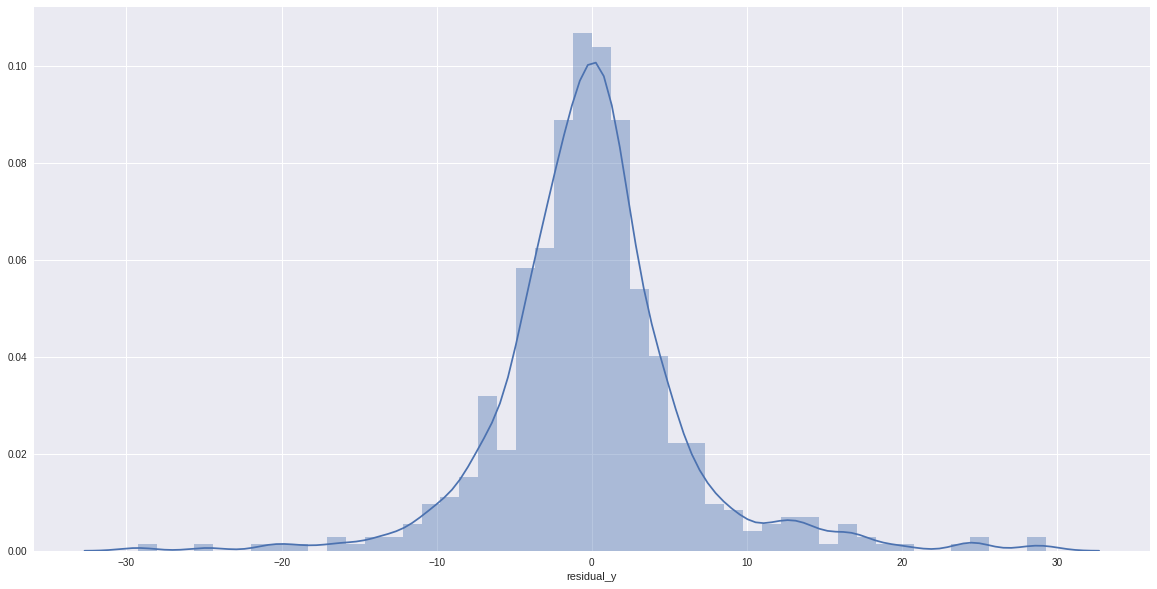

In [7]:
plt.figure(figsize=(20,10))
sns.distplot(result['residual_y'])
print('mean:', np.mean(result['residual_y']))
print('std:', np.std(result['residual_y']))

#### Not X0-X8 duplicates

In [8]:
train_df_id_idx = train.set_index(['ID'], drop=True)
tot_cols = train_df_id_idx.columns
tot_cols = set(tot_cols) - set(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'])
train_df_id_idx = train_df_id_idx[list(tot_cols)]
df = train_df_id_idx.drop(['y'], axis=1).duplicated(keep=False)
dupes_X = train_df_id_idx.drop(['y'], axis=1)[df]
dupe_ids = dupes_X.index.values
dupes = train_df_id_idx[train_df_id_idx.index.isin(dupe_ids)]
train_columns = list(set(dupes.columns) - set(['ID', 'y']))
mean_y = dupes.groupby(train_columns).y.mean().reset_index().rename(columns={'y':'mean_y'})
median_y = dupes.groupby(train_columns).y.median().reset_index().rename(columns={'y':'mean_y'})
variance_y = dupes.groupby(train_columns).y.var().reset_index().rename(columns={'y':'variance_y'})
std_y = dupes.groupby(train_columns).y.std().reset_index().rename(columns={'y':'std_y'})
temp = pd.merge(dupes, mean_y, on=train_columns, how='left')
temp = pd.merge(temp, median_y, on=train_columns, how='left')
temp = pd.merge(temp, variance_y, on=train_columns, how='left')
temp = pd.merge(temp, std_y, on=train_columns, how='left')
result = temp.sort_index().sort_values(train_columns)
result['residual_y'] = result.y - result.mean_y_x

mean: 4.3591578881e-16
std: 6.79194233474


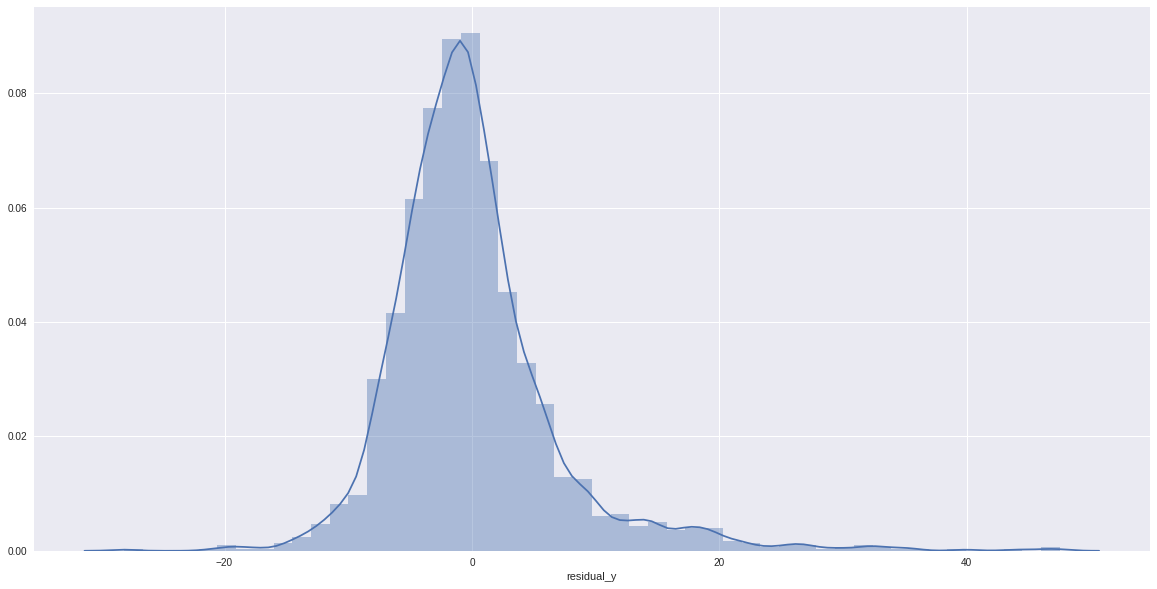

In [9]:
plt.figure(figsize=(20,10))
sns.distplot(result['residual_y'])
print('mean:', np.mean(result['residual_y']))
print('std:', np.std(result['residual_y']))